### Integral Image

Integral image is an extremely useful concept when we are facing the problem of summing up (rectangular) image regions (in pixel or in feature domain). In this notebook, we are going to show how to copmpute the integral image. In addition, we are going to measure the time for building a matrix holding the regional sums and compare the classical approach with the integral image approach.

In [1]:
import cv2
import numpy as np
from time import perf_counter
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Let's load an example image.

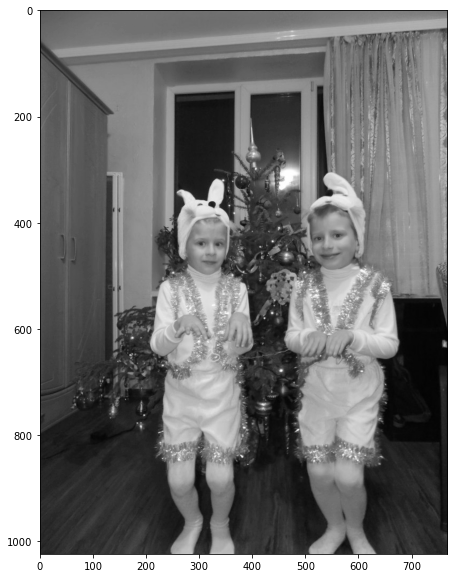

In [2]:
img = cv2.imread('data/my_sons.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')
img = img/255

### Regional Sums

In face detection, computing the regional pixel sums (for evaluating the Haar basis functions) is a crucial step. For this example, we are now going to huild the sum matrix using a 15x15 sliding window. For the sake of simplicity, we won't bother with the border areas.

In [3]:
rows, cols = img.shape
win = 15
sums = np.zeros((rows, cols))

# Start the computation
start = perf_counter()
# Sliding window
for r in range(win, rows-win-1):
    for c in range(win, cols-win-1):
        # Sum of pixel under the curren window
        sums[r, c] = np.sum(img[r-win:r+win+1, c-win:c+win+1])        
# Elapsed time for building the matrix of regional sums
elapsed = perf_counter() - start
print('Elapsed time:', elapsed)

Elapsed time: 14.307045000000016


### Integral Image

As we see above, building the sum matrix using the sliding window approach is quite slow. In fact, it is prohibitevly slow for real-time applications. Fortunately, we can make use of the integral image. Let's first build the integral image and then use it to build the matrix of regional sums.

In [4]:
sums_int_img = np.zeros((rows, cols))

start = perf_counter()
# Build integral image
int_img = img.cumsum(axis=0).cumsum(axis=1)
# Sliding window
for r in range(win, rows-win-1):
    for c in range(win, cols-win-1):
        # Summation of only 4 elements
        sums_int_img[r, c] = int_img[r+win, c+win] - \
                             int_img[r+win, c-win-1] - \
                             int_img[r-win-1, c+win] + \
                             int_img[r-win-1, c-win-1]
                        
elapsed = perf_counter() - start
print('Elapsed time:', elapsed)

Elapsed time: 3.0692158999999606


By using the integral image the computation time has decreased 4 times! Not bad, but can we do better? We know that python is not extremely efficient when it comes to loops. Therefore, can we get (somehow) rid of them?

The asnwer is that we can. We can obtain the same results but first adjusting the regional matrices (A. B, C, D) by rolling their axes. Afterwards, the calculation of the matrix of regional sums is just a summation of four matrices.

In [5]:
start = perf_counter()
# Build integral image
int_img = img.cumsum(axis=0).cumsum(axis=1)
# Build matrices for A, B, C and D regions (by axis rolling)
# Note: positive shift parameter rolls to the left,
# therefore the signs are inverted when compared to the loop above
A = np.roll(np.roll(int_img, win+1, axis=0), win+1, axis=1)
B = np.roll(np.roll(int_img, win+1, axis=0), -win, axis=1)
C = np.roll(np.roll(int_img, -win, axis=0), win+1, axis=1)
D = np.roll(np.roll(int_img, -win, axis=0), -win, axis=1)

result = D - B - C + A
elapsed = perf_counter() - start
print('Elapsed time:', elapsed)

Elapsed time: 0.11634470000001329


We have managed to reduce the time much further. The computation is now around 100 times faster!

In [6]:
# Lets check the results
N = 400
print(sums[N, N])
print(sums_int_img[N, N])
print(result[N, N])

247.7450980392157
247.745098039195
247.745098039195


In [7]:
# Average diff between sliding window vs integral image
np.mean(np.abs(sums[win+1:-win-1, win+1:-win-1] - sums_int_img[win+1:-win-1, win+1:-win-1]))

2.3838493353019377e-11

In [8]:
# Average diff between integral image vs "clever" integral image
np.mean(np.abs(sums_int_img[win+1:-win-1, win+1:-win-1] - result[win+1:-win-1, win+1:-win-1]))

1.3890478295403089e-14